In [1]:
import sys
sys.path.append('/cluster/home/bdayan/girgs/nemo-eva/src/')
sys.path+= ['/cluster/apps/nss/gcc-6.3.0/python_gpu/3.8.5', '/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python38.zip', '/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8', '/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/lib-dynload']
import os
os.chdir('/cluster/home/bdayan/girgs/benji_src/')

import numpy as np

# import feature_extractor


#
# from feature_extractor import FeatureExtractor

import pandas as pd
import glob

import os
import do_feature_extract
import networkit

from benji_girgs import utils, mcmc, generation, points
import networkit as nk
import networkx as nx

import matplotlib.pyplot as plt
import multiprocessing as mp
import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



os.environ['DATA_PATH'] = '/cluster/home/bdayan/girgs/FE_FB_copyweights_cube/'

df = pd.read_csv(os.environ['DATA_PATH'] + '2-features/results.csv')
df.Info = df.Info.apply(lambda temp: {key: eval(var) for key, var in [x.split('=') for x in temp.split('|')]} if (type(temp) is str and '|' in temp) else {
    })
df['alpha'] = df.Info.apply(lambda x: x['alpha'] if 'alpha' in x else 1/float(x['t']) if 't' in x else None)
mini_df = df.loc[df.Model == '1d-copyweight-cube-girg'].sort_values('Nodes').loc[:,['Graph', 'Model', 'Nodes', 'Info'] ]


/cluster/scratch/bdayan/GIRG_data/socfb-Berkeley13.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-American75.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-UConn.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-MSU24.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Brandeis99.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Virginia63.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Duke14.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Indiana69.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Swarthmore42.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Georgetown15.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Reed98.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-UC64.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Bowdoin47.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-UChicago30.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-Middlebury45.SpaceOne
/cluster/scratch/bdayan/GIRG_data/socfb-MIT.SpaceOne
/cluster

In [2]:
import os
os.getcwd()
os.environ['DATA_PATH'] = '/cluster/home/bdayan/girgs/FE_FB_chunglu_with_tau/'

df = pd.read_csv(os.environ['DATA_PATH'] + '3-cleaned_features/results.csv')

df.Info = df.Info.apply(lambda temp: {key: eval(var) for key, var in [x.split('=') for x in temp.split('|')]} if (type(temp) is str and '|' in temp) else {
    })
df['alpha'] = df.Info.apply(lambda x: x['alpha'] if 'alpha' in x else 1/float(x['t']) if 't' in x else None)

df.loc[df.Model == 'real-world'].sort_values('Nodes').loc[:, ['Graph', 'Model', 'Nodes', 'Info']]

'/cluster/home/bdayan/girgs/benji_src'

,Graph,Model,Nodes,Info
2977,socfb-Caltech36,real-world,762,{}
1365,socfb-Reed98,real-world,962,{}
156,socfb-Haverford76,real-world,1446,{}
900,socfb-Simmons81,real-world,1510,{}
94,socfb-Swarthmore42,real-world,1657,{}
...,...,...,...,...
466,socfb-UIllinois,real-world,30795,{}
2419,socfb-UIllinois20,real-world,30795,{}
1985,socfb-Texas80,real-world,31538,{}
2450,socfb-MSU24,real-world,32361,{}


In [65]:
gd = list(filter(lambda x: x['Name'] == 'socfb-Simmons81', do_feature_extract.graph_dicts))[0]
in_path = gd['FullPath']
in_path
name = gd['Name']
g = networkit.readGraph(in_path, networkit.Format.EdgeListSpaceOne)
g = utils.get_largest_component(g)
nk.overview(g)
n = g.numberOfNodes()

'/cluster/scratch/bdayan/GIRG_data/socfb-Simmons81.SpaceOne'

Network Properties:
nodes, edges			1510, 32984
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.028951
clustering coefficient		0.316606
min/max/avg degree		1, 300, 43.687417
degree assortativity		-0.060695
number of connected components	1
size of largest component	1510 (100.00 %)


In [66]:
import importlib
importlib.reload(mcmc)

<module 'benji_girgs.mcmc' from '/cluster/home/bdayan/girgs/benji_src/benji_girgs/mcmc.py'>

In [67]:
d2 = 2
mc_name = f'{n} node {name} {d2}d fit cube GIRG'

a, B, pts = utils.get_diffmap_and_points(g, ds=d2, process='restrict_uniform_edges')
pts = points.PointsCube(pts)
weights = np.array(utils.graph_degrees_to_weights(g))

alpha = 1.2

MC = mcmc.MCMC_girg(g, weights.copy(), alpha, 1.0, pts.copy(), pool=False, graph_name=mc_name,
                    failure_prob=0.3, cl_mixin_prob=0.5)
self=MC

MC.to_pytorch()

/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:174: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(wuwv, dists**d)


const: 1.0, expected_num_edges: 173053.75702873006, desired_edges: 32984
const: 0.19059973366844649, expected_num_edges: 98445.93282228016, desired_edges: 32984
const: 0.051315544492726246, expected_num_edges: 60588.17373888861, desired_edges: 32984
const: 0.021904360831131203, expected_num_edges: 44558.76869560785, desired_edges: 32984
const: 0.01353701186897562, expected_num_edges: 37838.50631084875, desired_edges: 32984
const: 0.010572741585291933, expected_num_edges: 34931.39975390277, desired_edges: 32984
const: 0.009426756377265708, expected_num_edges: 33700.47825853931, desired_edges: 32984


/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:161: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)
/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:735: RuntimeWarning: divide by zero encountered in divide
  puv = np.stack([np.ones(original_edge_dists.shape), const_in * ((wu * wv / W) / original_edge_dists ** d) ** alpha]).min(axis=0)
/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:736: RuntimeWarning: divide by zero encountered in divide
  puv_cube = np.stack([np.ones(cube_edge_dists.shape), const_in * ((wu * wv / W) / cube_edge_dists ** d) ** alpha]).min(axis=0)


In [68]:
g_out, A_out, out, pec, pfew = MC.get_CM(MC.A)
out
pec

array([[  12100,   53868],
       [  54408, 2159724]])

0.18342226534077127

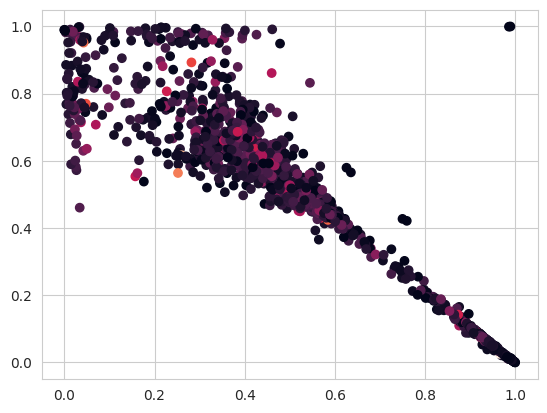

In [69]:
plt.scatter(MC.pts[:, 0], MC.pts[:, 1], c=MC.weights)

In [70]:
MC.ordered_pts_const_alpha_loop_pytorch(lr=1e-4, use_tqdm=True, num_loops=5, num_alpha_proposals=3)

100%|██████████| 1510/1510 [00:02<00:00, 521.63it/s]


{'loop': 0, 'll': tensor(-235237.4688), 'out': array([[  12382,   53586],
       [  51634, 2162498]]), 'pec': 0.18769706524375454, 'no_failure_cl_pec': 0.21031409168081494, 'no_failure_cl_out': array([[  13874,   52094],
       [  52048, 2162084]]), 'alpha': 1.3027635359666536}


100%|██████████| 1510/1510 [00:02<00:00, 521.58it/s]


{'loop': 1, 'll': tensor(-228085.3906), 'out': array([[  14432,   51536],
       [  51752, 2162380]]), 'pec': 0.2187727382973563, 'no_failure_cl_pec': 0.24305723987387826, 'no_failure_cl_out': array([[  16034,   49934],
       [  49812, 2164320]]), 'alpha': 1.276988130284875}


100%|██████████| 1510/1510 [00:02<00:00, 521.15it/s]


{'loop': 2, 'll': tensor(-224065.0469), 'out': array([[  15644,   50324],
       [  50722, 2163410]]), 'pec': 0.23714528256124182, 'no_failure_cl_pec': 0.26021707494542806, 'no_failure_cl_out': array([[  17166,   48802],
       [  48684, 2165448]]), 'alpha': 1.276988130284875}


100%|██████████| 1510/1510 [00:02<00:00, 522.00it/s]


{'loop': 3, 'll': tensor(-221229.1094), 'out': array([[  15990,   49978],
       [  49908, 2164224]]), 'pec': 0.24239024981809362, 'no_failure_cl_pec': 0.26858476837254425, 'no_failure_cl_out': array([[  17718,   48250],
       [  48398, 2165734]]), 'alpha': 1.276988130284875}


100%|██████████| 1510/1510 [00:02<00:00, 526.29it/s]


{'loop': 4, 'll': tensor(-219121.8125), 'out': array([[  16864,   49104],
       [  49100, 2165032]]), 'pec': 0.2556390977443609, 'no_failure_cl_pec': 0.28034804753820036, 'no_failure_cl_out': array([[  18494,   47474],
       [  47156, 2166976]]), 'alpha': 1.2951560581030124}


,loop,ll,out,pec,no_failure_cl_pec,no_failure_cl_out,alpha
0,0,tensor(-235237.4688),"[[12382, 53586], [51634, 2162498]]",0.187697,0.210314,"[[13874, 52094], [52048, 2162084]]",1.302764
1,1,tensor(-228085.3906),"[[14432, 51536], [51752, 2162380]]",0.218773,0.243057,"[[16034, 49934], [49812, 2164320]]",1.276988
2,2,tensor(-224065.0469),"[[15644, 50324], [50722, 2163410]]",0.237145,0.260217,"[[17166, 48802], [48684, 2165448]]",1.276988
3,3,tensor(-221229.1094),"[[15990, 49978], [49908, 2164224]]",0.242390,0.268585,"[[17718, 48250], [48398, 2165734]]",1.276988
4,4,tensor(-219121.8125),"[[16864, 49104], [49100, 2165032]]",0.255639,0.280348,"[[18494, 47474], [47156, 2166976]]",1.295156


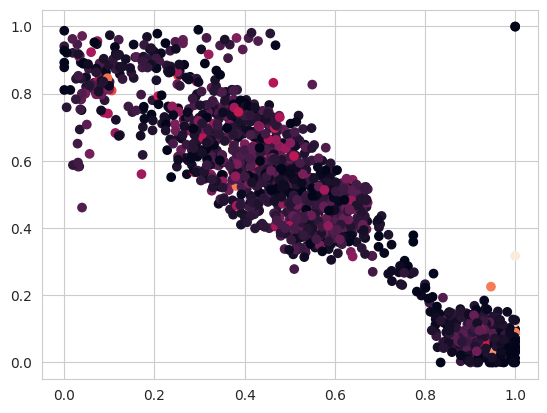

In [71]:
plt.scatter(MC.pts[:, 0], MC.pts[:, 1], c=MC.weights)

In [75]:
d2 = 2
mc_name = f'{n} node {name} {d2}d fit cube GIRG'

a, B, pts = utils.get_diffmap_and_points(g, ds=d2, process='restrict_uniform_edges')
pts = points.PointsCube(pts)
weights = np.array(utils.graph_degrees_to_weights(g))

alpha = 1.2

MC = mcmc.MCMC_girg(g, weights.copy(), alpha, 1.0, pts.copy(), pool=False, graph_name=mc_name,
                    failure_prob=0.3, cl_mixin_prob=0.3)
self=MC

MC.to_pytorch()

/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:174: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(wuwv, dists**d)


const: 1.0, expected_num_edges: 229103.217411877, desired_edges: 32984
const: 0.14397004272839195, expected_num_edges: 111202.87628945158, desired_edges: 32984
const: 0.033488592516252226, expected_num_edges: 59390.13527475912, desired_edges: 32984
const: 0.014700141165557361, expected_num_edges: 41254.1187256338, desired_edges: 32984
const: 0.010276828701694385, expected_num_edges: 35276.47220725644, desired_edges: 32984
const: 0.009106087760152991, expected_num_edges: 33488.24912188044, desired_edges: 32984
const: 0.008833922636493902, expected_num_edges: 33056.57274639196, desired_edges: 32984


/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:161: RuntimeWarning: divide by zero encountered in divide
  p_uv = np.divide(outer, dists**d)
/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:735: RuntimeWarning: divide by zero encountered in divide
  puv = np.stack([np.ones(original_edge_dists.shape), const_in * ((wu * wv / W) / original_edge_dists ** d) ** alpha]).min(axis=0)
/cluster/home/bdayan/girgs/benji_src/benji_girgs/generation.py:736: RuntimeWarning: divide by zero encountered in divide
  puv_cube = np.stack([np.ones(cube_edge_dists.shape), const_in * ((wu * wv / W) / cube_edge_dists ** d) ** alpha]).min(axis=0)


In [76]:
MC.ordered_pts_const_alpha_loop_pytorch(lr=1e-4, use_tqdm=True, num_loops=5, num_alpha_proposals=3)

100%|██████████| 1510/1510 [00:02<00:00, 533.86it/s]


{'loop': 0, 'll': tensor(-242549.0469), 'out': array([[  12442,   53526],
       [  54024, 2160108]]), 'pec': 0.18860659713800632, 'no_failure_cl_pec': 0.19742905651224837, 'no_failure_cl_out': array([[  13024,   52944],
       [  52896, 2161236]]), 'alpha': 1.3027635359666536}


100%|██████████| 1510/1510 [00:02<00:00, 524.35it/s]


{'loop': 1, 'll': tensor(-228497.6562), 'out': array([[  13826,   52142],
       [  51898, 2162234]]), 'pec': 0.20958646616541354, 'no_failure_cl_pec': 0.23308270676691728, 'no_failure_cl_out': array([[  15376,   50592],
       [  50218, 2163914]]), 'alpha': 1.1866722929148557}


100%|██████████| 1510/1510 [00:02<00:00, 526.53it/s]


{'loop': 2, 'll': tensor(-221223.7031), 'out': array([[  14890,   51078],
       [  50992, 2163140]]), 'pec': 0.22571549842347804, 'no_failure_cl_pec': 0.2526073247635217, 'no_failure_cl_out': array([[  16664,   49304],
       [  49242, 2164890]]), 'alpha': 1.117121185696376}


100%|██████████| 1510/1510 [00:02<00:00, 523.66it/s]


{'loop': 3, 'll': tensor(-216964.8594), 'out': array([[  15686,   50282],
       [  50002, 2164130]]), 'pec': 0.23778195488721804, 'no_failure_cl_pec': 0.25815546931845745, 'no_failure_cl_out': array([[  17030,   48938],
       [  48744, 2165388]]), 'alpha': 1.074301620594553}


100%|██████████| 1510/1510 [00:02<00:00, 525.16it/s]


{'loop': 4, 'll': tensor(-214080.6562), 'out': array([[  15948,   50020],
       [  50010, 2164122]]), 'pec': 0.2417535774921174, 'no_failure_cl_pec': 0.27055542081008976, 'no_failure_cl_out': array([[  17848,   48120],
       [  48580, 2165552]]), 'alpha': 1.0474712937635209}


,loop,ll,out,pec,no_failure_cl_pec,no_failure_cl_out,alpha
0,0,tensor(-242549.0469),"[[12442, 53526], [54024, 2160108]]",0.188607,0.197429,"[[13024, 52944], [52896, 2161236]]",1.302764
1,1,tensor(-228497.6562),"[[13826, 52142], [51898, 2162234]]",0.209586,0.233083,"[[15376, 50592], [50218, 2163914]]",1.186672
2,2,tensor(-221223.7031),"[[14890, 51078], [50992, 2163140]]",0.225715,0.252607,"[[16664, 49304], [49242, 2164890]]",1.117121
3,3,tensor(-216964.8594),"[[15686, 50282], [50002, 2164130]]",0.237782,0.258155,"[[17030, 48938], [48744, 2165388]]",1.074302
4,4,tensor(-214080.6562),"[[15948, 50020], [50010, 2164122]]",0.241754,0.270555,"[[17848, 48120], [48580, 2165552]]",1.047471


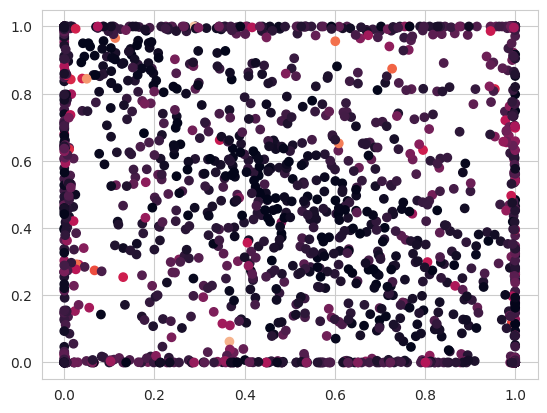

In [74]:
plt.scatter(MC.pts[:, 0], MC.pts[:, 1], c=MC.weights)

In [43]:
import importlib
importlib.reload(mcmc)

<module 'benji_girgs.mcmc' from '/cluster/home/bdayan/girgs/benji_src/benji_girgs/mcmc.py'>

In [44]:
d2 = 2
mc_name = f'{n} node {name} {d2}d fit cube GIRG'

a, B, pts = utils.get_diffmap_and_points(g, ds=d2, process='restrict_uniform_edges')
pts = points.PointsCube(pts)
weights = np.array(utils.graph_degrees_to_weights(g))

alpha = 1.2

MC = mcmc.MCMC_girg(g, weights.copy(), alpha, 1.0, pts.copy(), pool=False, graph_name=mc_name,
                    failure_prob=0.0, cl_mixin_prob=0.0)
self=MC

MC.to_pytorch()

const: 1.0, expected_num_edges: 235550.40230264832, desired_edges: 18812
const: 0.07986401133728183, expected_num_edges: 103070.319045304, desired_edges: 18812
const: 0.01037319971412344, expected_num_edges: 31671.135951047956, desired_edges: 18812
const: 0.005002563393042208, expected_num_edges: 18789.882472635254, desired_edges: 18812
const: 0.005011988328916311, expected_num_edges: 18816.206084735113, desired_edges: 18812
const: 0.005009971868605497, expected_num_edges: 18810.575694267245, desired_edges: 18812
const: 0.0050107305909245035, expected_num_edges: 18812.694268366024, desired_edges: 18812


In [45]:
MC.const

0.005010323781976534

In [46]:
MC.outs

[(array([[  6872,  30752],
         [ 30868, 856952]]),
  0)]

In [47]:
g_out, A_out, out, pec, pfew = MC.get_CM(MC.A)
out
pec

array([[  6720,  30904],
       [ 30622, 857198]])

0.17860939825643207

In [49]:
MC.failure_prob
MC.cl_mixin_prob

0.0

0.0

In [31]:
for _ in range(7):
    self.ll, self.expected_num_edges = self.calculate_ll()
    print(f'const: {self.const}, expected_num_edges: {self.expected_num_edges}')
    self.calibrate_const()

const: 0.0003910936847631046, expected_num_edges: 2328.667724609375
const: 0.20618787903488175, expected_num_edges: 152014.25
const: 0.00039076451299887015, expected_num_edges: 2326.9521484375
const: 0.2064703296163216, expected_num_edges: 152088.03125
const: 0.0003907306770982358, expected_num_edges: 2326.77294921875
const: 0.20650017331426165, expected_num_edges: 152095.890625
const: 0.0003907265879448271, expected_num_edges: 2326.75244140625
